## Titanic游客生存率预测

### 报告将从以下几方面进行分析与建模：
### - 数据导入与理解
### - 数据预处理
### - 数据关系分析
### - 特征工程
### - 建模
### - 模型优化

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1. 数据导入与理解

In [28]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [29]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Unnamed: 12
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,NaN
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN


In [30]:
train.drop(columns=["Unnamed: 12"],inplace=True)

In [31]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [32]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### 2. 数据预处理

### 我们观察到年龄、船舱以及登船未知有缺失值

### 对于登船位置，缺失值较少，可以用众数填充

In [34]:
train.Embarked.fillna(train.Embarked.mode()[0], inplace=True)

### 船舱属性值缺失过多，可以将其分为有和无两类，没有船舱也代表一种信息

In [35]:
train.loc[ train.Cabin.notnull(), 'Cabin' ] = 'Yes'
train.loc[ train.Cabin.isnull(), 'Cabin' ] = 'No'

### 对于年龄缺失值，由于这一属性比较重要，可以通过均值简单填充，或通过模型预测,这里有些属性尚未转换为数值型，所以暂时选取数值型变量进行预测

In [36]:
from sklearn.ensemble import RandomForestRegressor

#选择训练集
age_df = train[['Age','Survived','Fare', 'Parch', 'SibSp', 'Pclass']]
age_df_notnull=age_df.loc[age_df["Age"].notnull()]
age_df_isnull = age_df.loc[train['Age'].isnull()]
X=age_df_notnull.values[:,1:]
Y = age_df_notnull.values[:,0]

# 使用随即森林预测
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
RFR.fit(X,Y)
predictAges = RFR.predict(age_df_isnull.values[:,1:])
train.loc[train['Age'].isnull(),['Age']]= predictAges

### 3. 数据关系分析

### 3.1整体存活率分析

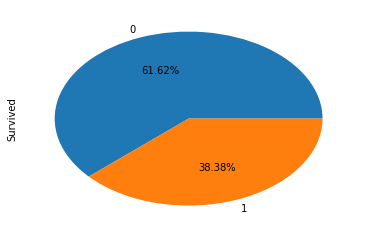

In [12]:
train.Survived.value_counts().plot.pie(autopct = '%1.2f%%')

### 3.2性别与存活率分析

In [13]:
train.groupby(['Sex','Survived']).Sex.count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Sex, dtype: int64

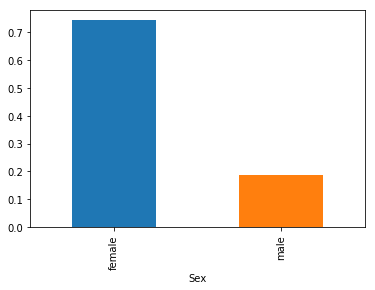

In [14]:
train.groupby('Sex')['Survived'].mean().plot.bar()

### 女性存活率高于男性

### 3.3船舱等级与生存与否

In [115]:
train.groupby(["Pclass",'Survived']).Pclass.count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Pclass, dtype: int64

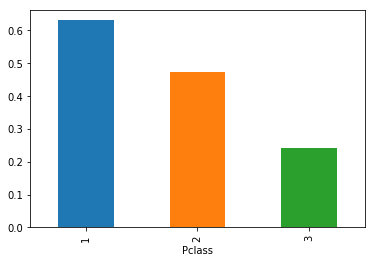

In [119]:
train.groupby('Pclass').Survived.mean().plot.bar()

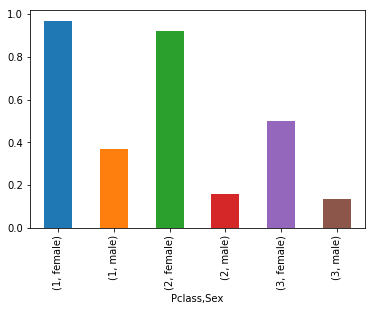

In [120]:
train.groupby(['Pclass','Sex'])['Survived'].mean().plot.bar()

### 船舱等级越高，获救可能性越大

### 3.4不同年龄与获救可能性

C:\Users\DELL\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


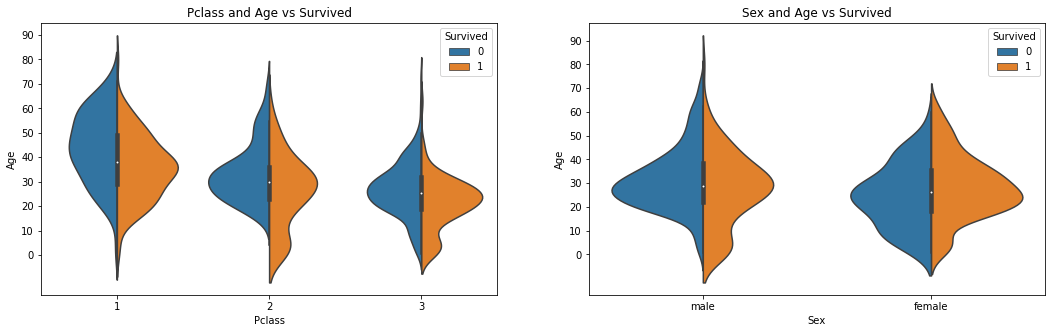

In [125]:
fig,ax = plt.subplots(1,2, figsize = (18,5))
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Pclass","Age",hue="Survived",data=train,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived') 

ax[1].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age",hue="Survived",data=train,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
 
plt.show()

### 年龄分布图

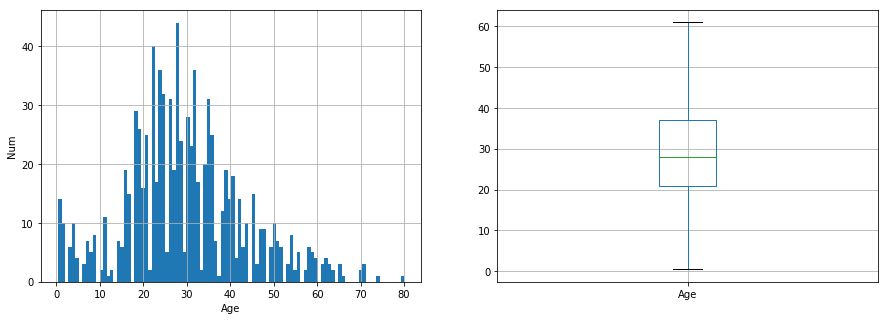

In [126]:
plt.figure(figsize=(15,5))
plt.subplot(121)
train['Age'].hist(bins=100)
plt.xlabel('Age')
plt.ylabel('Num')
 
plt.subplot(122)
train.boxplot(column='Age',showfliers=False)
plt.show()

### 不同年龄下生存与死亡的分布情况

C:\Users\DELL\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


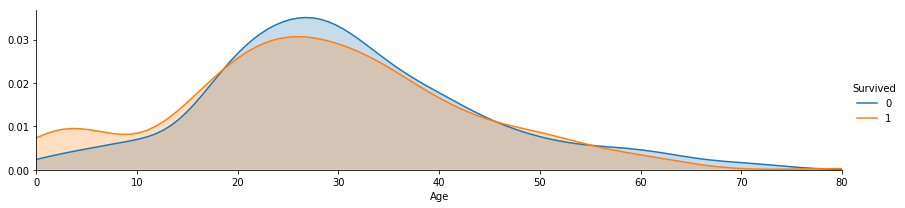

In [129]:
facet = sns.FacetGrid(train,hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0,train['Age'].max()))
facet.add_legend()

In [15]:
train['Age'].describe()

count    891.000000
mean      29.663942
std       13.738543
min        0.420000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

### 样本有891，平均年龄约为30岁，标准差13.5岁，最小年龄0.42，最大年龄80.按照年龄，将乘客划分为儿童、少年、成年、老年，分析四个群体的生还情况

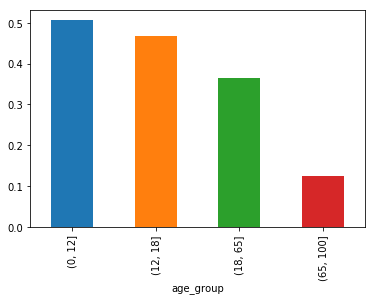

In [17]:
bins=[0,12,18,65,100]
train['age_group']=pd.cut(train['Age'],bins)
train.groupby('age_group').Survived.mean().plot.bar()

### 3.5 有无兄弟姐妹与存活可能性

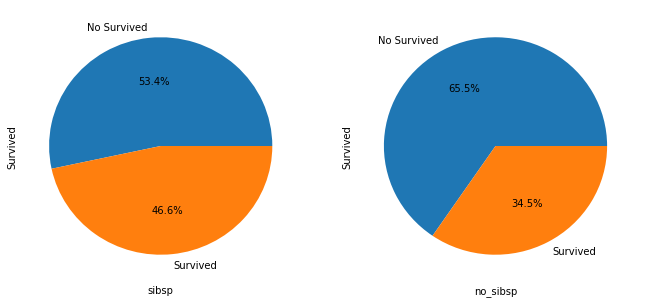

In [22]:
sibsp_df=train[train['SibSp']!=0]
no_sibsp_df=train[train['SibSp']==0]
plt.figure(figsize=(11,5))
plt.subplot(121)
sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct= '%1.1f%%')
plt.xlabel('sibsp')
 
plt.subplot(122)
no_sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct= '%1.1f%%')
plt.xlabel('no_sibsp')
 
plt.show()

### 4. 特征工程

### 4.1 dummy variable(哑变量)

#### 类别变量或者二元变量，当qualitative variable是一些频繁出现的几个独立变量时，Dummy Variables比较适用。Embarked只包含三个值’S'，‘C'，’Q'，可以将其转换为dummies：

In [38]:
embark_dummies = pd.get_dummies(train['Embarked'])
train = train.join(embark_dummies)
train.drop(['Embarked'], axis=1, inplace=True)

embark_dummies = train[['S','C','Q']]
embark_dummies.head()

,S,C,Q
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


In [75]:
train_dummies_Sex = pd.get_dummies(train['Sex'], prefix='Sex')
train = train.join(train_dummies_Sex)
train.drop(['Sex'], axis=1, inplace=True)

In [77]:
train_dummies_Pclass = pd.get_dummies(train['Pclass'], prefix='Pclass')
train = train.join(train_dummies_Pclass)
train.drop(['Pclass'], axis=1, inplace=True)

In [79]:
def family_size_category(family_size):
    if family_size <= 1:
        return 'Single'
    elif family_size <= 4:
        return 'Small_Family'
    else:
        return 'Large_Family'

In [82]:
train['Family_Size']=train['Parch']+train['SibSp']
train['Family_Size_Category'] = train['Family_Size'].map(family_size_category)

In [ ]:
train_dummies_family = pd.get_dummies(train['Family_Size_Category'], prefix='Family_Size_Category')
train = train.join(train_dummies_family)
train.drop(['Family_Size_Category'], axis=1, inplace=True)
train.drop(['Family_Size'], axis=1, inplace=True)

In [92]:
train.drop(['SibSp'], axis=1, inplace=True)
train.drop(['Parch'], axis=1, inplace=True)

In [93]:
train.head()

,PassengerId,Survived,Name,Ticket,C,Q,S,No,Yes,Age_scaled,...,"Fare_(21.679, 39.688]","Fare_(39.688, 512.329]",Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Family_Size_Category_Large_Family,Family_Size_Category_Single,Family_Size_Category_Small_Family
0,1,0,"Braund, Mr. Owen Harris",A/5 21171,0,0,1,1,0,-0.558344,...,0,0,0,1,0,0,1,0,1,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,1,0,0,0,1,0.607255,...,0,1,1,0,1,0,0,0,1,0
2,3,1,"Heikkinen, Miss. Laina",STON/O2. 3101282,0,0,1,1,0,-0.266944,...,0,0,1,0,0,0,1,0,1,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,0,0,1,0,1,0.388705,...,0,1,1,0,1,0,0,0,1,0
4,5,0,"Allen, Mr. William Henry",373450,0,0,1,1,0,0.388705,...,0,0,0,1,0,0,1,0,1,0


### 4.2 factoring

#### dummy不好处理Cabin（船舱号）标称属性，因为出现的变量较多。Pandas有一方法叫做factorize()，它可以创建一些数字，来表示类别变量，对每一个类别映射一个ID.

In [59]:
cabin_dummies = pd.get_dummies(train['Cabin'])
train = train.join(cabin_dummies)
train.drop(['Cabin'], axis=1, inplace=True)

cabin_dummies.head()

,No,Yes
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0


 ### 4.3 sacling

#### Scaling可以将一个很大范围的数值映射到一个很小范围（通常是 -1到1，或者是0到1），否则大范围数特征将会有更高的权重。比如：Age的范围可能只是0-100，而income的范围可能是0-10000000，在某些对数组大小敏感的模型中会影响其结果.

In [62]:
from sklearn import preprocessing

assert np.size(train['Age']) == 891
scaler = preprocessing.StandardScaler()
train['Age_scaled'] = scaler.fit_transform(train['Age'].values.reshape(-1,1))

In [64]:
train.drop(['Age'], axis=1, inplace=True)

### 4.4 binning

#### Binning通过观察“邻居”（即周围的值）将连续数据离散化。存储的值被分布到一些“桶”或“箱”中，就像直方图的bin将数据划分成几块一样,对fare做区间划分。

In [69]:
train['Fare_bin'] = pd.qcut(train['Fare'],5)
print(train['Fare_bin'].head())

0      (-0.001, 7.854]
1    (39.688, 512.329]
2        (7.854, 10.5]
3    (39.688, 512.329]
4        (7.854, 10.5]
Name: Fare_bin, dtype: category
Categories (5, interval[float64]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.679] < (21.679, 39.688] < (39.688, 512.329]]


#### 在将数据Binning化后，要么将数据factorize化，要么dummies化

In [73]:
fare_bin_dummies_df = pd.get_dummies(train['Fare_bin']).rename(columns=lambda x: 'Fare_' + str(x))
train = pd.concat([train, fare_bin_dummies_df], axis=1)
train.drop(['Fare'], axis=1, inplace=True)

In [96]:
train.drop(['PassengerId','Name','Ticket','Fare_bin'],axis=1,inplace=True)

In [195]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived                             891 non-null float64
Q                                    891 non-null float64
S                                    891 non-null float64
No                                   891 non-null float64
Yes                                  891 non-null float64
Age_scaled                           891 non-null float64
Fare_(-0.001, 7.854]                 891 non-null float64
Fare_(7.854, 10.5]                   891 non-null float64
Fare_(10.5, 21.679]                  891 non-null float64
Fare_(21.679, 39.688]                891 non-null float64
Fare_(39.688, 512.329]               891 non-null float64
Sex_female                           891 non-null float64
Sex_male                             891 non-null float64
Pclass_1                             891 non-null float64
Pclass_2                             891 non-null float64
Pclass_3                 

In [152]:
train=train.T.drop_duplicates().T

### 5. 建立模型 logistic回归模型

In [177]:
from sklearn.linear_model import LogisticRegression

In [196]:
train_y=train.values[:,0]
train_x=train.values[:,1:]
#lr = LogisticRegression()

#lr.fit(train_x,train_y)

In [179]:
predictions = lr.predict(train_x)

In [180]:
from collections import Counter

a = Counter(predictions==train_y)

In [181]:
print(a)
726/(726+165)

Counter({True: 726, False: 165})


0.8148148148148148

### 6. 模型优化

### 6.1 随机森林

#### 网格搜索最优参数

In [199]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation,metrics
from sklearn import model_selection

In [211]:
pipe=Pipeline([('select',SelectKBest(k=15)),
               ('classify',RandomForestClassifier(random_state=10,max_features='sqrt'))])
param_test={'classify__n_estimators':list(range(20,50,2)),'classify__max_depth':list(range(3,60,3))}
gsearch=GridSearchCV(estimator=pipe,param_grid=param_test,scoring='roc_auc',cv=10)
gsearch.fit(train_x,train_y)
print(gsearch.best_params_,gsearch.best_score_)

{'classify__max_depth': 9, 'classify__n_estimators': 46} 0.8812896671779619


In [212]:
from sklearn.ensemble import RandomForestClassifier
random_forest=RandomForestClassifier(warm_start=True,random_state=1,n_estimators=46,max_depth=9,max_features='sqrt',min_samples_split=4,min_samples_leaf=2)

In [213]:
random_forest.fit(train_x,train_y)
predictions = random_forest.predict(train_x)

In [214]:
from collections import Counter
a = Counter(predictions==train_y)
print(a)
775/(775+116)

Counter({True: 801, False: 90})


0.8698092031425365

### 6.2 可视化不同特征的影响

In [204]:
import matplotlib.pyplot as plt
features_list=train.columns.values

In [205]:
forest=RandomForestClassifier(oob_score=True,n_estimators=10000)
forest.fit(train_x,train_y)
feature_importance=forest.feature_importances_
print(feature_importance)

[0.01197659 0.03237578 0.02801617 0.02742403 0.40668699 0.01573034
 0.01258465 0.01458045 0.01504406 0.02049354 0.142843   0.14005422
 0.02126306 0.01832924 0.04794567 0.01286019 0.01487603 0.01691599]


In [206]:
feature_importance=100.0*(feature_importance/feature_importance.max())

In [207]:
important_idx=np.where(feature_importance)[0]

In [208]:
sorted_idx=np.argsort(feature_importance[important_idx])[::-1]

In [209]:
pos=np.arange(sorted_idx.shape[0])+.5

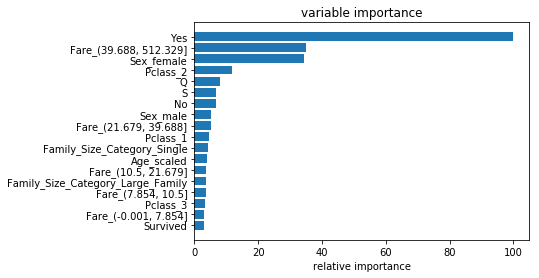

In [210]:
plt.barh(pos,feature_importance[important_idx][sorted_idx[::-1]])
plt.yticks(pos,features_list[sorted_idx[::-1]])
plt.xlabel('relative importance')
plt.title('variable importance')
plt.show()

In [170]:
train.drop(['C'],axis=1,inplace=True)